In [20]:
%autoreload
%autoreload 2

from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import calendar
from sklearn.linear_model import LinearRegression
from datetime import datetime
import numpy as np
import calendar
from tqdm.auto import tqdm



from ts_diagnostics import cross_validation, performance_metrics



In [2]:
def clean_data(df, min_val, max_val):
    return df[df['energy_demand'].between(min_val, max_val)].set_index('energy_timestamp_mtn')

In [3]:
# define the max and min dates to pull training data from BQ
data_start = datetime(2015, 8, 1)
data_end = datetime(2021, 6, 1)

q = "SELECT * FROM `mlops-zoomcamp-354700.energy_data_prod.joined_temp_and_demand`"
df_raw = pd.read_gbq(q, project_id='mlops-zoomcamp-354700')
df_train_raw = df_raw[df_raw['energy_timestamp_mtn'].between(data_start, data_end)]
             

In [4]:
# make features
df_train = (clean_data(df_train_raw, 2000, 11_000).reset_index()
                                                 .dropna(subset=['energy_demand', 'temp_F'])
                                                 .assign(
                                                        year=lambda df_: df_['energy_timestamp_mtn'].dt.year,
                                                        day_of_year=lambda df_: df_['energy_timestamp_mtn'].dt.day_of_year,
                                                        hour=lambda df_: df_['energy_timestamp_mtn'].dt.hour,
                                                        is_weekend=lambda df_: df_['energy_timestamp_mtn'].dt.day_of_week >= 5, # saturady day_of_week = 5, sunday = 6
                                                        is_summer=lambda df_: df_['energy_timestamp_mtn'].dt.month.between(5, 9, inclusive='both'),
                                                        month=lambda df_: df_['energy_timestamp_mtn'].dt.month,
                                                        temp_F_squared=lambda df_: df_['temp_F'] * df_['temp_F'],                                                        
                                                )
            
                                            .set_index('energy_timestamp_mtn')                                    
          )


for month in calendar.month_name[1:]:
    df_train[month] = pd.to_numeric(df_train.index.month_name == month)



In [5]:
# define start and end of training data for the model
train_start = datetime(2015, 8, 1)
train_end = datetime(2021, 1, 1)
time_filter =  (df_train.index > train_start) & (df_train.index < train_end)

# filter training data
X = df_train.loc[time_filter,
                    ['temp_F', 'year', 'day_of_year', 'hour', 'is_weekend', 'is_summer', 'month', 'temp_F_squared']
                ] 
y = df_train.loc[time_filter, 'energy_demand']

In [6]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# predict the training set
X_pred = X.assign(predicted= model.predict(X),
                 energy_demand=y)

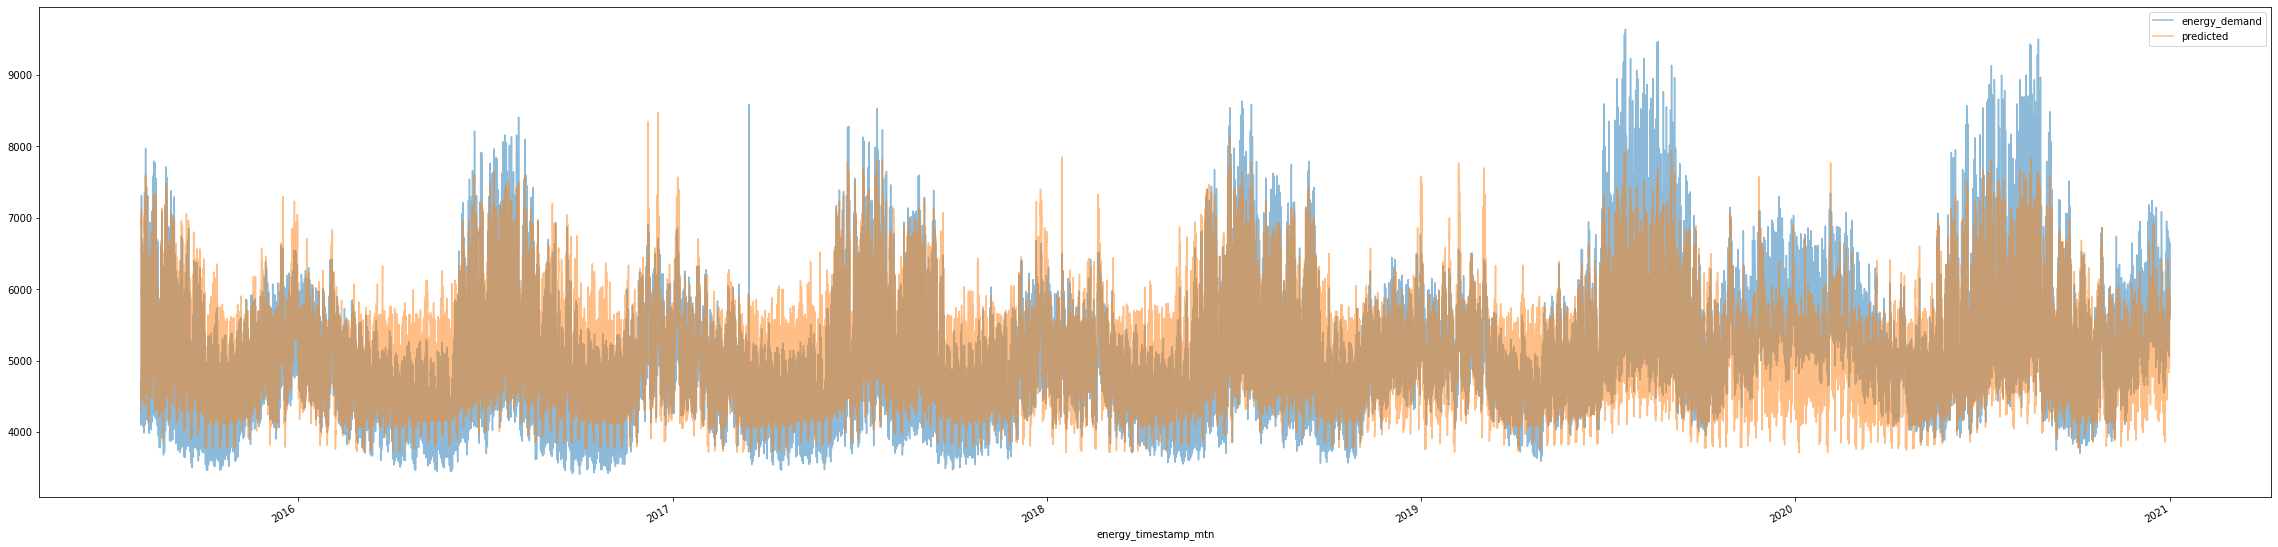

In [7]:
# visualize predicted vs actual on all of training set
X_pred[['energy_demand', 'predicted']].plot(alpha=0.5, figsize=(40,10));

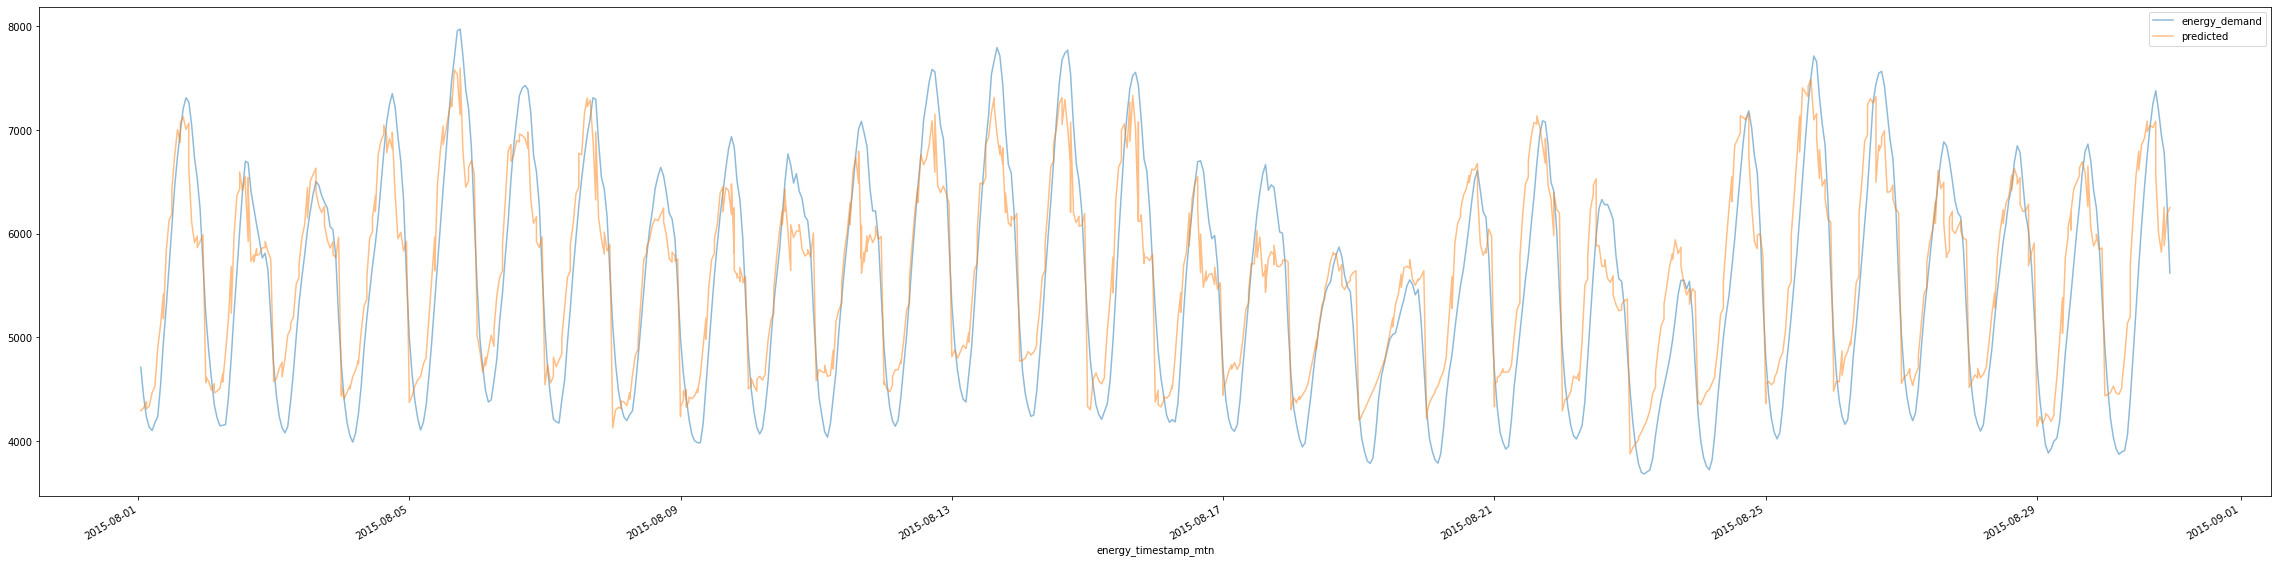

In [8]:
# visualize predicted vs actual on zoomed in portion of the training set
start_time = pd.to_datetime('2015-08-01')
end_time = pd.to_datetime('2015-08-31')

date_filter = (X_pred.index > start_time) &  (X_pred.index < end_time)
X_pred.loc[date_filter, ['energy_demand', 'predicted']].plot(alpha=0.5, figsize=(40,10));

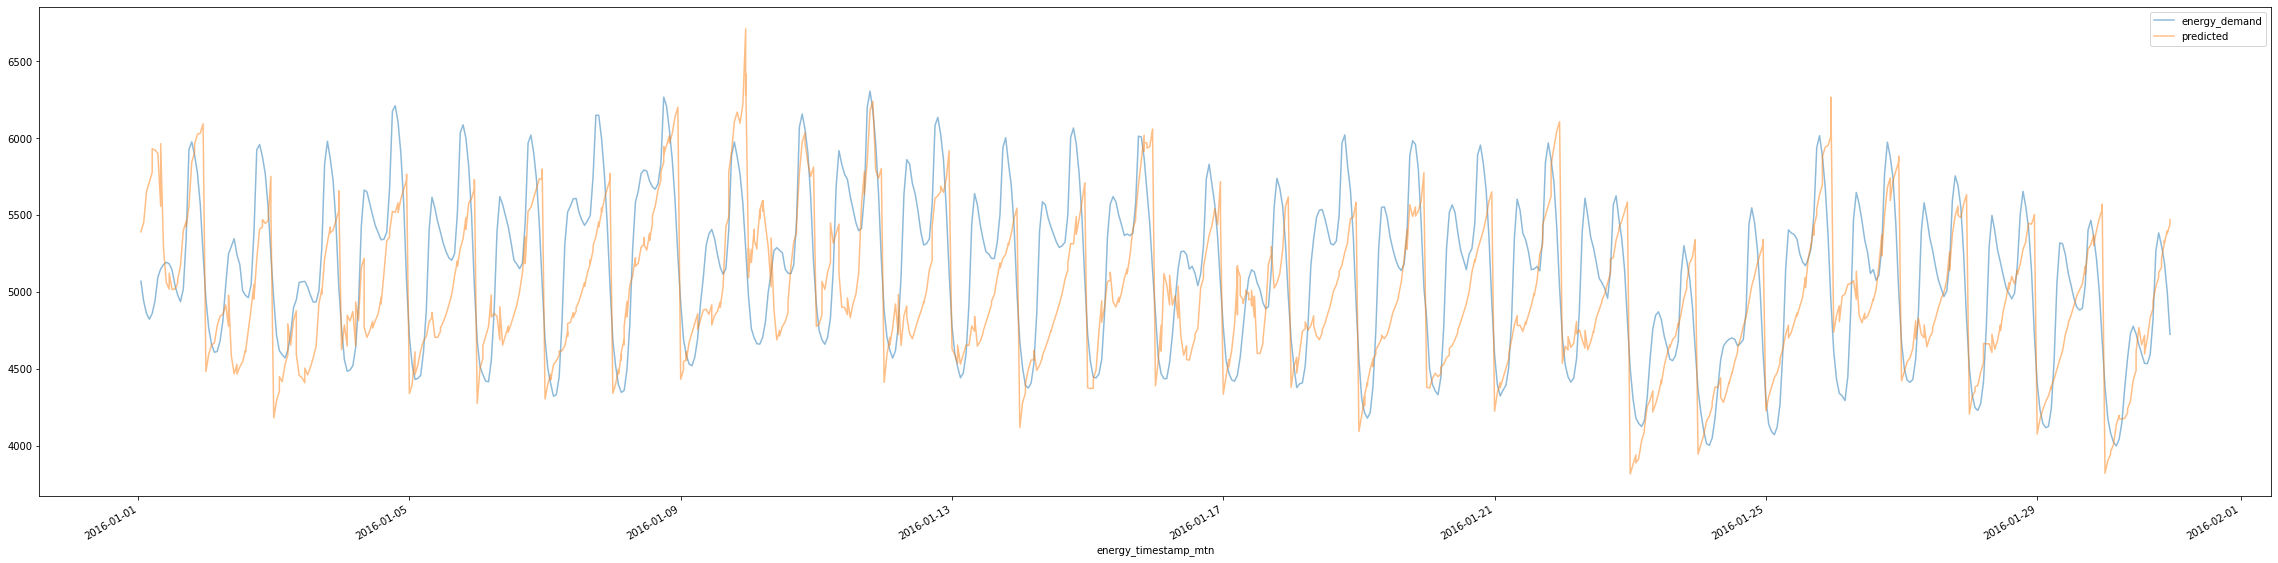

In [10]:
# visualize predicted vs actual on zoomed in portion of the training set
start_time = pd.to_datetime('2016-01-01')
end_time = pd.to_datetime('2016-01-31')

date_filter = (X_pred.index > start_time) &  (X_pred.index < end_time)
X_pred.loc[date_filter, ['energy_demand', 'predicted']].plot(alpha=0.5, figsize=(40,10));

In [11]:
# predict on a range of data not included in the training set
pred_start = datetime(2021, 1, 1)
pred_end = datetime(2021, 6, 1)

time_filter =  (df_train.index > pred_start) & (df_train.index < pred_end)
X_val = df_train.loc[time_filter,
                    ['temp_F', 'year', 'day_of_year', 'hour', 'is_weekend', 'is_summer', 'month', 'temp_F_squared']
                ] 
y_val = df_train.loc[time_filter, 'energy_demand']
X_pred_val = X_val.assign(predicted= model.predict(X_val),
                 energy_demand=y_val)


<AxesSubplot:xlabel='energy_timestamp_mtn'>

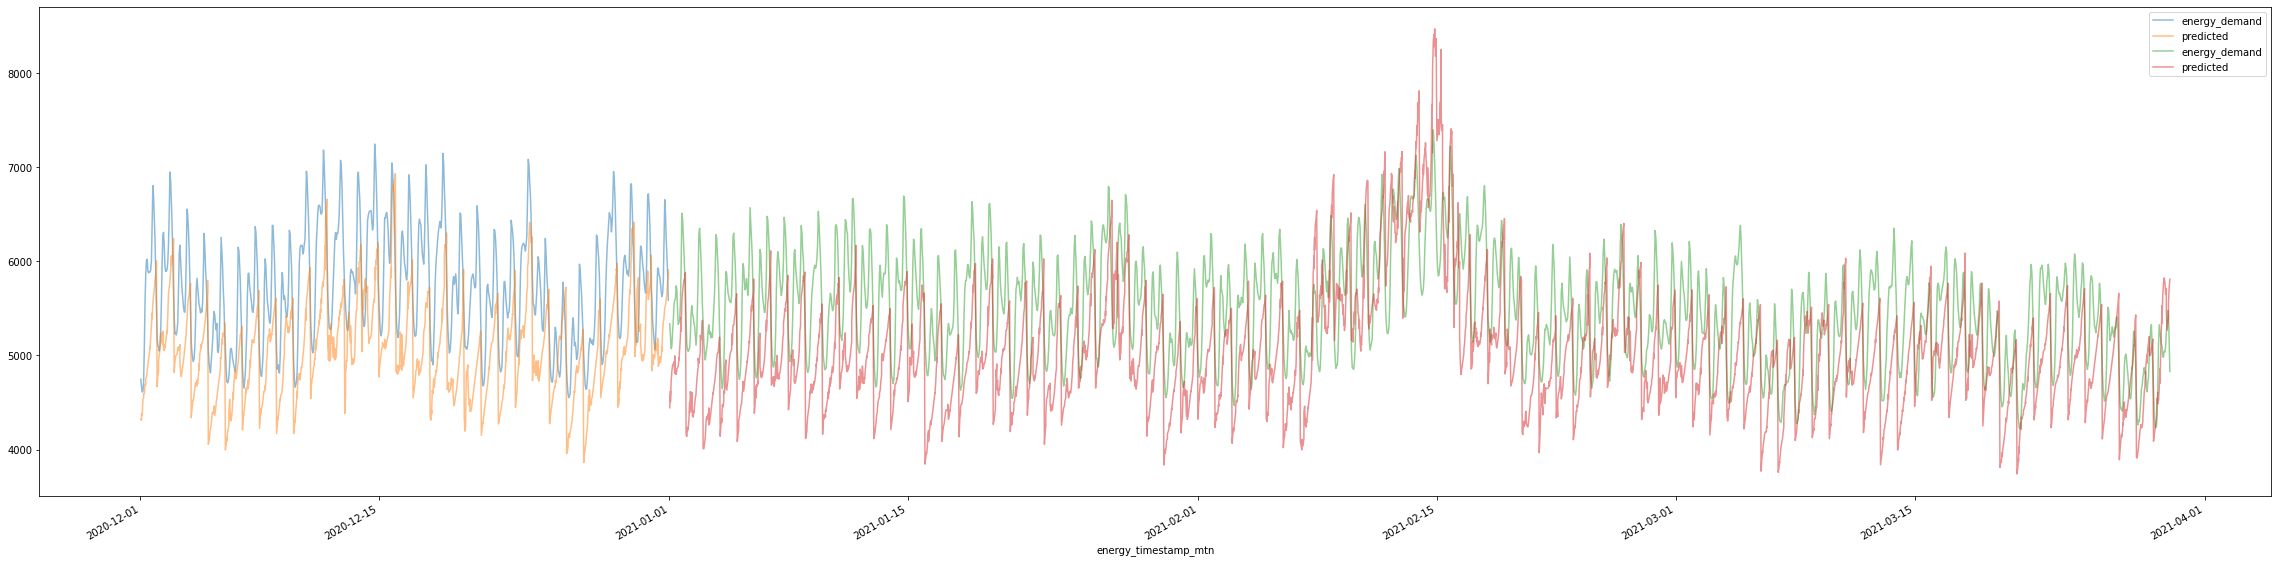

In [12]:
start_time = pd.to_datetime('2020-12-01')
end_time = pd.to_datetime('2021-03-30')

date_filter = (X_pred.index > start_time) &  (X_pred.index < end_time)
ax = X_pred.loc[date_filter, ['energy_demand', 'predicted']].plot(alpha=0.5, figsize=(40,10))
date_filter = (X_val.index > start_time) &  (X_val.index < end_time)
X_pred_val.loc[date_filter, ['energy_demand', 'predicted']].plot(alpha=0.5, figsize=(40,10), ax=ax)

In [13]:
horizon = '2 days'
initial = f'{4 * 365} days'
period = '55 days'

df_cv = cross_validation(model, 
                 X, 
                 y, 
                 horizon, 
                 period, 
                 initial)
                 
df_cv

Making 10 forecasts with cutoffs between 2019-08-22 23:00:00 and 2020-12-29 23:00:00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 45.87it/s]


,temp_F,year,day_of_year,hour,is_weekend,is_summer,month,temp_F_squared,ds,y,yhat,cutoff
0,91.0,2019,235,14,False,True,8,8281.00,2019-08-23 14:00:00,7336.0,6896.171512,2019-08-22 23:00:00
1,91.0,2019,235,15,False,True,8,8281.00,2019-08-23 15:00:00,7550.0,6956.876304,2019-08-22 23:00:00
2,64.0,2019,236,8,True,True,8,4096.00,2019-08-24 08:00:00,4877.0,4561.030515,2019-08-22 23:00:00
3,64.0,2019,236,9,True,True,8,4096.00,2019-08-24 09:00:00,5093.0,4621.735308,2019-08-22 23:00:00
4,68.0,2019,235,2,False,True,8,4624.00,2019-08-23 02:00:00,4958.0,4696.664041,2019-08-22 23:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
687,42.1,2020,366,14,False,False,12,1772.41,2020-12-31 14:00:00,5626.0,5038.187241,2020-12-29 23:00:00
688,33.1,2020,365,10,False,False,12,1095.61,2020-12-30 10:00:00,6053.0,4942.359886,2020-12-29 23:00:00
689,33.1,2020,365,11,False,False,12,1095.61,2020-12-30 11:00:00,5967.0,5004.387624,2020-12-29 23:00:00
690,33.1,2020,366,9,False,False,12,1095.61,2020-12-31 09:00:00,5926.0,4880.905051,2020-12-29 23:00:00


In [14]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape
0,2 days,457515.857342,676.399185,537.802347,0.094569,0.087042,0.098186


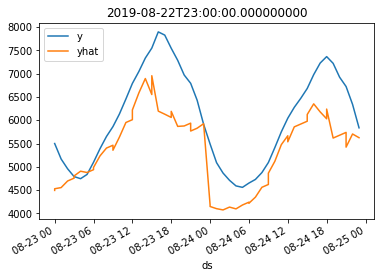

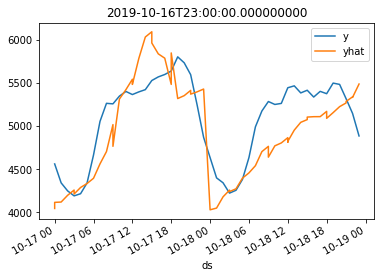

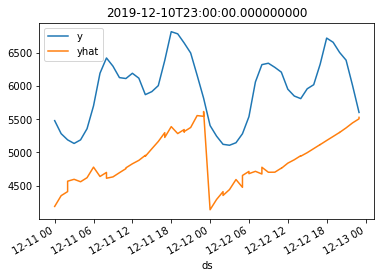

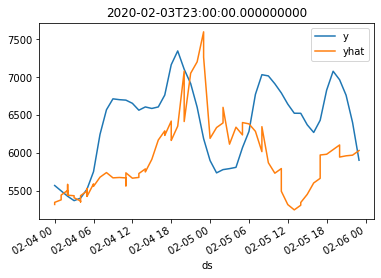

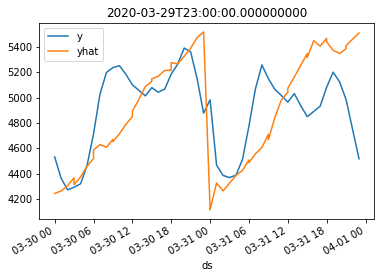

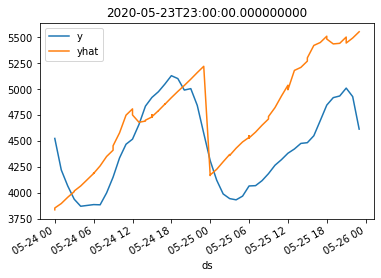

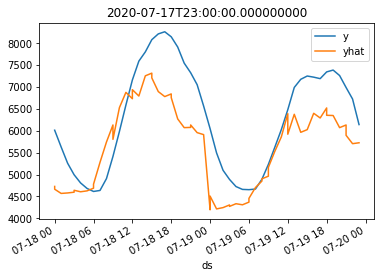

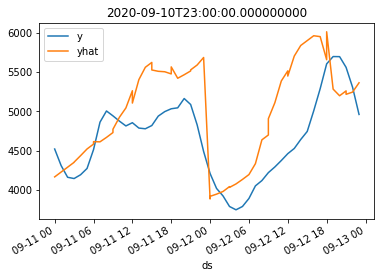

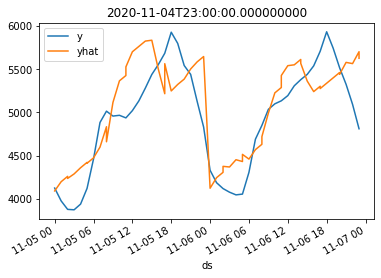

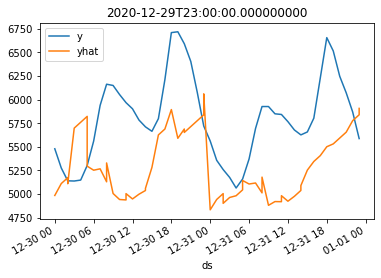

In [15]:
for cutoff in df_cv.cutoff.unique():
    df = df_cv[df_cv['cutoff'] == cutoff]
    df.plot(x='ds', y=['y', 'yhat']).set(title=cutoff)